In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
print("The version of tidy3d is:", td.__version__, "(important to match the version with the GUI version in the website.)")


The version of tidy3d is: 2.5.0 (important to match the version with the GUI version in the website.)


## Calculating slab transmission.

In [3]:
# Wavelength and frequency ranges.
freq_range = (200e12, 400e12)
lambda_range = (td.constants.C_0 / freq_range[1], td.constants.C_0 / freq_range[0]) # just a conversion from frequency to wavelength using the speed of light.
freq0 = np.sum(freq_range) / 2
Nfreq = 301

# Wavelength and frequency monitors.
monitor_freq = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freq

# Central frequency, freqcuency pulse width and total running time
lambda0 = td.C_0 / freq0
bandwidth = 0.18 # bandwidth of source in units of delta frequency. 0.38 for broadband.

freqw = bandwidth * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thickness and refractive index of slab.
t_slab = 0.5
n_slab = 3.5
mat_slab = td.Medium(permittivity=n_slab**2, name='silicon')

# Grid resolution (cells per um)
# dl = lambda_range[0] / 30 / n_slab
dl = 6e-3

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (2.0, 2.0, 2*spacing + t_slab)

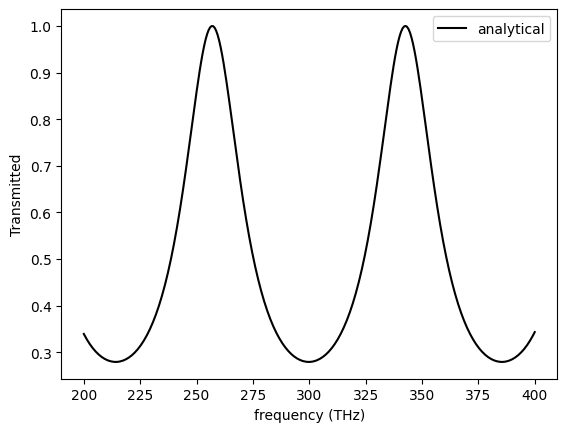

In [5]:
# Analytical solution.
# Computes transmission as a function of slab thickness (d), refractive index (n), and wavelength (wvl).
def slab_analytical(d, n, wvl):
    rho = (n-1)/(n+1)
    t = ((1+rho)*(1-rho)*np.exp(-2j*np.pi*n*d/wvl)) / (1 - rho**2*np.exp(-4j*np.pi*n*d/wvl))
    return np.abs(t)**2

transmission_analytical = slab_analytical(t_slab, n_slab, monitor_lambdas)

plt.figure()
plt.plot(monitor_freq / 1e12, transmission_analytical, 'k', label='analytical')
plt.xlabel('frequency (THz)')
plt.ylabel('Transmitted')
plt.legend()
plt.show()

In [10]:
# Define the multilayer stack structure.

slab = td.Structure(
    geometry = td.Box(
        center = (0, 0, -Lz/2 + spacing + t_slab/2),
        size = (td.inf, td.inf, t_slab),
        
    ),
    medium = mat_slab,
    name='slab',
)

# Define the planewave source, placed jsut in advance of the slab.
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size = (td.inf, td.inf, 0),
    center=(0, 0, -Lz/2 + spacing/2),
    direction='+',
    pol_angle=0,
    name="planewave",
)

# We set itthe transmitted flux to be an oversized plane.
monitor = td.FluxMonitor(
    center=(0, 0, Lz/2 - spacing/2),
    size=(td.inf, td.inf, 0),
    freqs=monitor_freq,
    name="flux",
)


In [12]:
# Define the simulation object.
sim = td.Simulation(
    center = (0,0,0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab],
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    boundary_spec = td.BoundarySpec.pml(z=True),
    normalize_index = None,
    
)

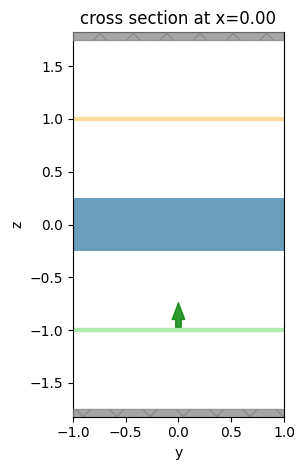

In [13]:
sim.plot(x=0)
plt.show()

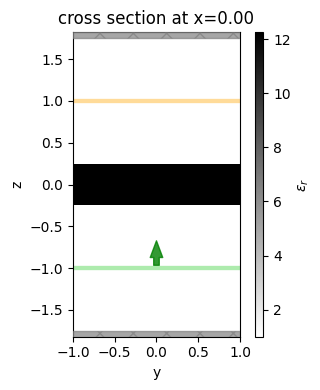

In [14]:
# plot the permittivity 
freqs_plot = (freq_range[0], freq_range[1])
fig, ax = plt.subplots(1, tight_layout=True, figsize=(8, 4))
sim.plot_eps(x=0, freq=None, ax=ax)
plt.show()

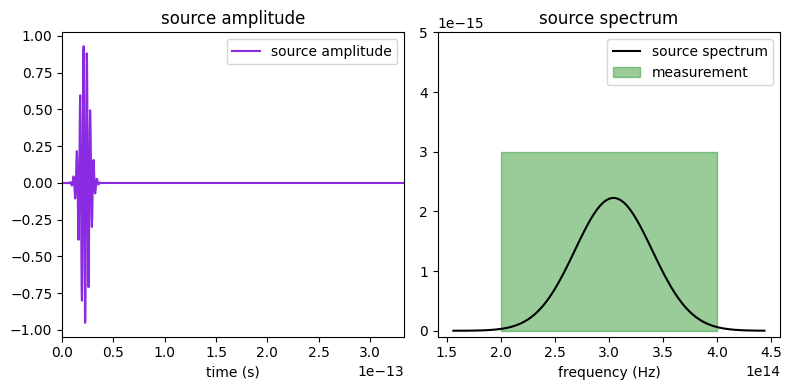

In [15]:
times = np.arange(0, sim.run_time, sim.dt)
amps = np.real(sim.sources[0].source_time.amp_time(times))

# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, sim.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim.run_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 1001), val='abs', ax=ax2)
fill_max = 30e-16 # 10e-16
ymax = 50e-16 # 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [16]:
# Result without the dielectric slab.
#! So that we can compare the results with and without the slab
#! And calculate the transmission in the slab structure.
sim0 = sim.copy(update={'structures':[]})


In [17]:
sim_data0 = web.run(sim0, task_name='lecture02_slab_narrowband_normalization', path=f'data/data0_narrowband.hdf5', verbose=True)
sim_data = web.run(sim, task_name='lecture02_slab_narrowband_transmission', path=f'data/data_narrowband.hdf5', verbose=True)

23:39:30 CST Created task 'lecture02_slab_narrowband_normalization' with task_id
             'fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=226699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=206237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\taskId]8;;\]8;id=226699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\=]8;;\]8;id=166903;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\fdve]8;;\]8;id=226699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\-bd8abd6c-3b3]8;;\
             ]8;id=226699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\1-4ff5-8ab8-d9308bd0af36']8;;\.

/Users/inhwankim/.local/lib/python3.10/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:39:32 CST status = queued

23:39:35 CST status = preprocess

23:39:39 CST You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:39:58 CST early shutoff detected at 16%, exiting.

             status = postprocess

23:40:01 CST status = success

             View simulation result at                                          
             ]8;id=481312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=244120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\taskId]8;;\]8;id=481312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\=]8;;\]8;id=682311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\fdve]8;;\]8;id=481312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\-bd8abd6c-3b3]8;;\
             ]8;id=481312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd8abd6c-3b31-4ff5-8ab8-d9308bd0af36\1-4ff5-8ab8-d9308bd0af36']8;;\.

23:40:02 CST loading simulation from data/data0_narrowband.hdf5

             Created task 'lecture02_slab_narrowband_transmission' with task_id 
             'fdve-97c13c82-f395-463e-9066-eb76d5c239fa' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=495173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=972750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\taskId]8;;\]8;id=495173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\=]8;;\]8;id=928658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\fdve]8;;\]8;id=495173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\-97c13c82-f39]8;;\
             ]8;id=495173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\5-463e-9066-eb76d5c239fa']8;;\.

23:40:04 CST status = queued

23:40:07 CST status = preprocess

23:40:11 CST You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:40:36 CST early shutoff detected at 28%, exiting.

             status = postprocess

23:40:40 CST status = success

             View simulation result at                                          
             ]8;id=967676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=321829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\taskId]8;;\]8;id=967676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\=]8;;\]8;id=863415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\fdve]8;;\]8;id=967676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\-97c13c82-f39]8;;\
             ]8;id=967676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c13c82-f395-463e-9066-eb76d5c239fa\5-463e-9066-eb76d5c239fa']8;;\.

23:40:41 CST loading simulation from data/data_narrowband.hdf5

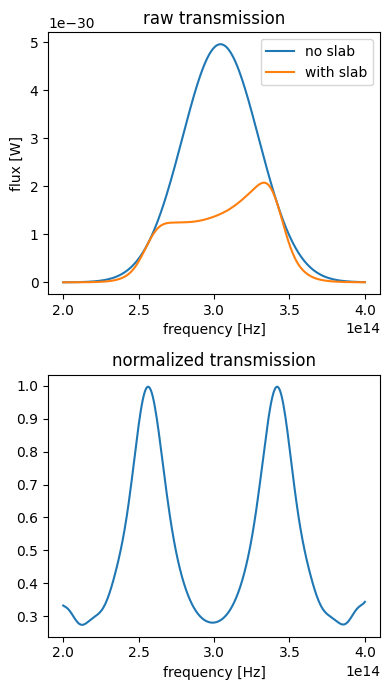

In [18]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_data0['flux'].flux
transmission = sim_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

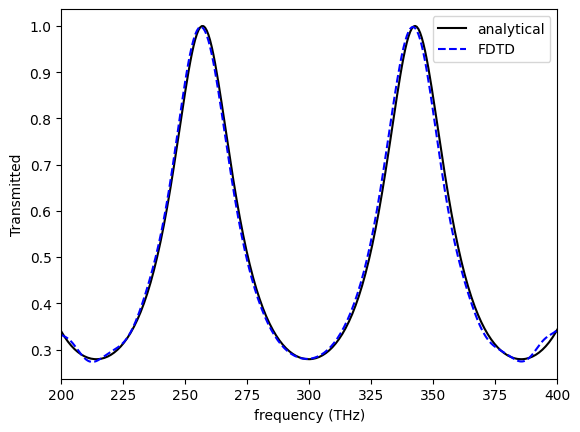

In [20]:
plt.figure()
plt.plot(monitor_freq/1e12, transmission_analytical, 'k', label='analytical')
plt.plot(monitor_freq/1e12, transmission_normalized, 'b--', label='FDTD')
plt.xlabel('frequency (THz)')
plt.xlim([200, 400])
plt.ylabel('Transmitted')
plt.legend()
plt.show()

The result does not look great at the edge of the frequencies. It is likely due to the source spectrum no having enough power in those regions.

In [31]:
bandwidth = 0.05

freqw  = bandwidth * (freq_range[1] - freq_range[0])

# make a copy of the original simulation, but change the frequency width of the source
bw_source = source.copy(update={
    'source_time':source.source_time.copy(update={'fwidth':freqw})
    }
)
sim_bw = sim.copy(update={'sources':[bw_source]})

# make the normalization simulation for this
sim_bw0 = sim_bw.copy(update={'structures':[]})

23:49:59 CST WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.600000e+14, 3.400000e+14)(Hz) as defined by the 
             sources.                                                           

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.600000e+14, 3.400000e+14)(Hz) as defined by the 
             sources.                                                           

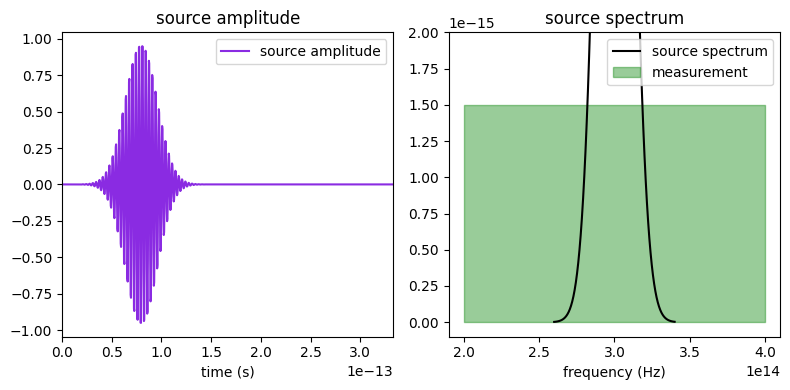

In [32]:
# Check probe and source, looks now like the source spectrum fully covers the green square
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1 = sim_bw.sources[0].source_time.plot(times=np.linspace(0, sim_bw.run_time, 1001), ax=ax1)
ax1.set_xlim(0, sim_bw.run_time)
ax1.legend(('source amplitude',))
ax2 = sim_bw.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim_bw.run_time, 1001), val='abs', ax=ax2)
fill_max = 15e-16
ymax = 20e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

In [33]:
sim_bw_data0 = web.run(sim_bw0, task_name='lecture02_slab_broadband_normalizatio', path=f'data/data0_broadband.hdf5')
sim_bw_data = web.run(sim_bw, task_name='lecture02_slab_broadband_transmission', path=f'data/data_broadband.hdf5')

23:50:11 CST Created task 'lecture02_slab_broadband_normalizatio' with task_id  
             'fdve-b8f66112-855d-4218-a03f-8fc73296993a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=980686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=632097;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\taskId]8;;\]8;id=980686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\=]8;;\]8;id=971721;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\fdve]8;;\]8;id=980686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\-b8f66112-855]8;;\
             ]8;id=980686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\d-4218-a03f-8fc73296993a']8;;\.

23:50:13 CST status = queued

23:50:16 CST status = preprocess

23:50:21 CST You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:50:52 CST early shutoff detected at 44%, exiting.

             status = postprocess

23:50:55 CST status = success

             View simulation result at                                          
             ]8;id=794348;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=65147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\taskId]8;;\]8;id=794348;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\=]8;;\]8;id=68795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\fdve]8;;\]8;id=794348;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\-b8f66112-855]8;;\
             ]8;id=794348;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b8f66112-855d-4218-a03f-8fc73296993a\d-4218-a03f-8fc73296993a']8;;\.

23:50:56 CST loading simulation from data/data0_broadband.hdf5

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.600000e+14, 3.400000e+14)(Hz) as defined by the 
             sources.                                                           

23:50:57 CST Created task 'lecture02_slab_broadband_transmission' with task_id  
             'fdve-0e054489-9b81-4f74-803d-0228474d402a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=836920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=264335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\taskId]8;;\]8;id=836920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\=]8;;\]8;id=815282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\fdve]8;;\]8;id=836920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\-0e054489-9b8]8;;\
             ]8;id=836920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\1-4f74-803d-0228474d402a']8;;\.

23:50:58 CST status = queued

23:51:01 CST status = preprocess

23:51:05 CST You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:51:37 CST early shutoff detected at 44%, exiting.

             status = postprocess

23:51:41 CST status = success

             View simulation result at                                          
             ]8;id=897779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=627132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\taskId]8;;\]8;id=897779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\=]8;;\]8;id=701663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\fdve]8;;\]8;id=897779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\-0e054489-9b8]8;;\
             ]8;id=897779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0e054489-9b81-4f74-803d-0228474d402a\1-4f74-803d-0228474d402a']8;;\.

23:51:42 CST loading simulation from data/data_broadband.hdf5

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.600000e+14, 3.400000e+14)(Hz) as defined by the 
             sources.                                                           

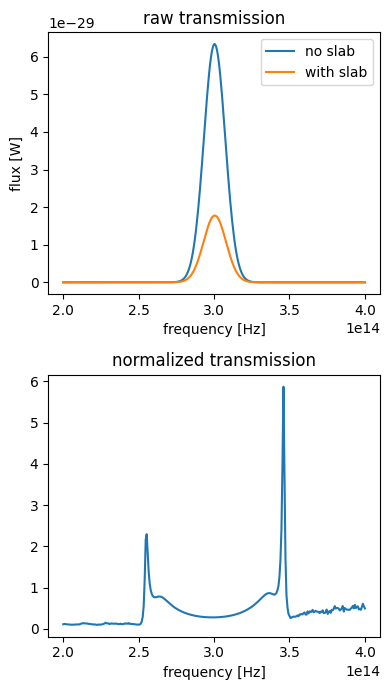

In [34]:
# Retrieve the power flux through the monitor plane.
transmission0 = sim_bw_data0['flux'].flux
transmission = sim_bw_data['flux'].flux
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7), tight_layout=True)
transmission0.plot(ax=ax1, label='no slab')
transmission.plot(ax=ax1, label='with slab')
transmission_normalized.plot(ax=ax2)
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()